In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

class ActiveLearner:
    def __init__(self, X, y, strategy, n_queries, n_samples, test_size=0.2):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        self.strategy = strategy
        self.n_queries = n_queries
        self.n_samples = n_samples
        self.labeled_indices = np.random.choice(len(self.X_train), size=int(0.2 * len(self.X_train)), replace=False)
        self.labeled_data = (self.X_train[self.labeled_indices], self.y_train[self.labeled_indices])
        self.unlabeled_indices = np.setdiff1d(range(len(self.X_train)), self.labeled_indices)
        self.unlabeled_data = (self.X_train[self.unlabeled_indices], self.y_train[self.unlabeled_indices])
        self.model = KNeighborsClassifier()
        self.model.fit(*self.labeled_data)
        self.accuracy_history = []

    def query(self):
        X_unlabeled, y_unlabeled = self.unlabeled_data
        indices = self.strategy.select(X_unlabeled, self.n_samples)
        X_queried, y_queried = X_unlabeled[indices], y_unlabeled[indices]
        self.labeled_data = (np.vstack((self.labeled_data[0], X_queried)),
                             np.concatenate((self.labeled_data[1], y_queried)))
        self.unlabeled_indices = np.delete(self.unlabeled_indices, indices, axis=0)
        self.unlabeled_data = (self.X_train[self.unlabeled_indices], self.y_train[self.unlabeled_indices])
        return X_queried, y_queried

    def train(self):
        self.reset()  # Modell zurücksetzen vor Beginn der Trainingsiterationen
        for _ in range(self.n_queries):
            X_queried, y_queried = self.query()
            self.model.fit(*self.labeled_data)
            y_pred = self.model.predict(self.X_test)
            accuracy = accuracy_score(self.y_test, y_pred)
            self.accuracy_history.append(accuracy)
        return self.accuracy_history

    def reset(self):
        self.model = KNeighborsClassifier()
        self.model.fit(*self.labeled_data)

In [2]:
from sklearn.cluster import KMeans
import os
os.environ["OMP_NUM_THREADS"] = "2"
from sklearn.metrics.pairwise import cosine_similarity

# uncertainty sampling
class LeastConfidence:
    def __init__(self, model):
        self.model = model

    def select(self, X, n_samples):
        prob_dist = self.model.predict_proba(X)
        most_conf = np.nanmax(prob_dist, axis=1)
        num_labels = prob_dist.shape[1]
        numerator = (num_labels * (1 - most_conf))
        denominator = (num_labels - 1)
        least_conf = numerator / denominator
        indices = np.argsort(least_conf)[:n_samples]
        return indices

class MarginConfidence:
    def __init__(self, model):
        self.model = model

    def select(self, X, n_samples):
        prob_dist = self.model.predict_proba(X)
        prob_dist[::-1].sort(axis=1)
        difference = (prob_dist[:, 0] - prob_dist[:, 1])
        margin_conf = 1 - difference
        indices = np.argsort(margin_conf)[:n_samples]
        return indices
    
# diversity sampling
class ClusterBasedSampling:
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state

    def select(self, X, n_samples):
        # Anwenden von KMeans Clustering
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        labels = kmeans.fit_predict(X)
        
        # Auswahl eines Samples aus jedem Cluster
        indices = []
        for i in range(self.n_clusters):
            cluster_indices = np.where(labels == i)[0]
            selected = np.random.choice(cluster_indices, size=min(n_samples, len(cluster_indices)), replace=False)
            indices.extend(selected)
        
        return np.array(indices)[:n_samples]
    
class RepresentativeSampling:
    def __init__(self, n_samples):
        self.n_samples = n_samples

    def select(self, X, n_samples):
        # Berechnung der Kosinus-Ähnlichkeit zwischen allen Punkten
        similarity = cosine_similarity(X)
        # Mittelwert der Ähnlichkeiten für jeden Punkt
        avg_similarity = np.mean(similarity, axis=1)
        # Auswahl der Datenpunkte mit der höchsten durchschnittlichen Ähnlichkeit
        indices = np.argsort(avg_similarity)[-n_samples:]
        
        return indices


In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Basiskonfiguration der Parameter
base_params = {
    'n_samples': 2000,
    'n_features': 20,
    'n_informative': 10,
    'n_redundant': 5,
    'n_classes': 3,
    'n_clusters_per_class': 2,
    'class_sep': 0.5,
    'random_state': 42
}

# Anpassungen der Parameter
modifications = [
    {'n_classes': 2},
    {'n_classes': 2, 'class_sep': 0.3},
    {'n_classes': 2, 'class_sep': 0.8},
    {'n_classes': 2, 'class_sep': 1.2},
    {'n_clusters_per_class': 4},
    {'n_clusters_per_class': 4, 'class_sep': 0.3},
    {'n_clusters_per_class': 4, 'class_sep': 0.8},
    {'n_clusters_per_class': 4, 'class_sep': 1.2},
]

# Parameter Sets kombinieren
parameter_sets = [{**base_params, **mod} for mod in modifications]

results = {}

In [18]:
# Experimente durchführen
queries=50
samples=10

for params in parameter_sets:
    X, y = make_classification(**params)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Vollständig gelabeltes Modell trainieren
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    baseline_accuracy = accuracy_score(y_test, y_pred)


    strategies = [LeastConfidence, MarginConfidence, ClusterBasedSampling, RepresentativeSampling]
    strategy_results = {}
    strategy_results['FullyLabeled'] = [baseline_accuracy] * queries
    
    for Strategy in strategies:
        if Strategy == ClusterBasedSampling:
            strategy_instance = Strategy(n_clusters=5)  # Pass the correct number of clusters
        else:
            model = KNeighborsClassifier()
            model.fit(X_train, y_train)  # Modell initial trainieren
            strategy_instance = Strategy(model)  # Strategieinstanz mit Modell
        
        learner = ActiveLearner(X_train, y_train, strategy_instance, n_queries=queries, n_samples=samples)
        accuracy_history = learner.train()
        strategy_results[Strategy.__name__] = accuracy_history
    
    results[str(params)] = strategy_results

c:\Users\marwi\anaconda3\envs\hcai\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\marwi\anaconda3\envs\hcai\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\marwi\anaconda3\envs\hcai\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\marwi\anaconda3\envs\hcai\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans 

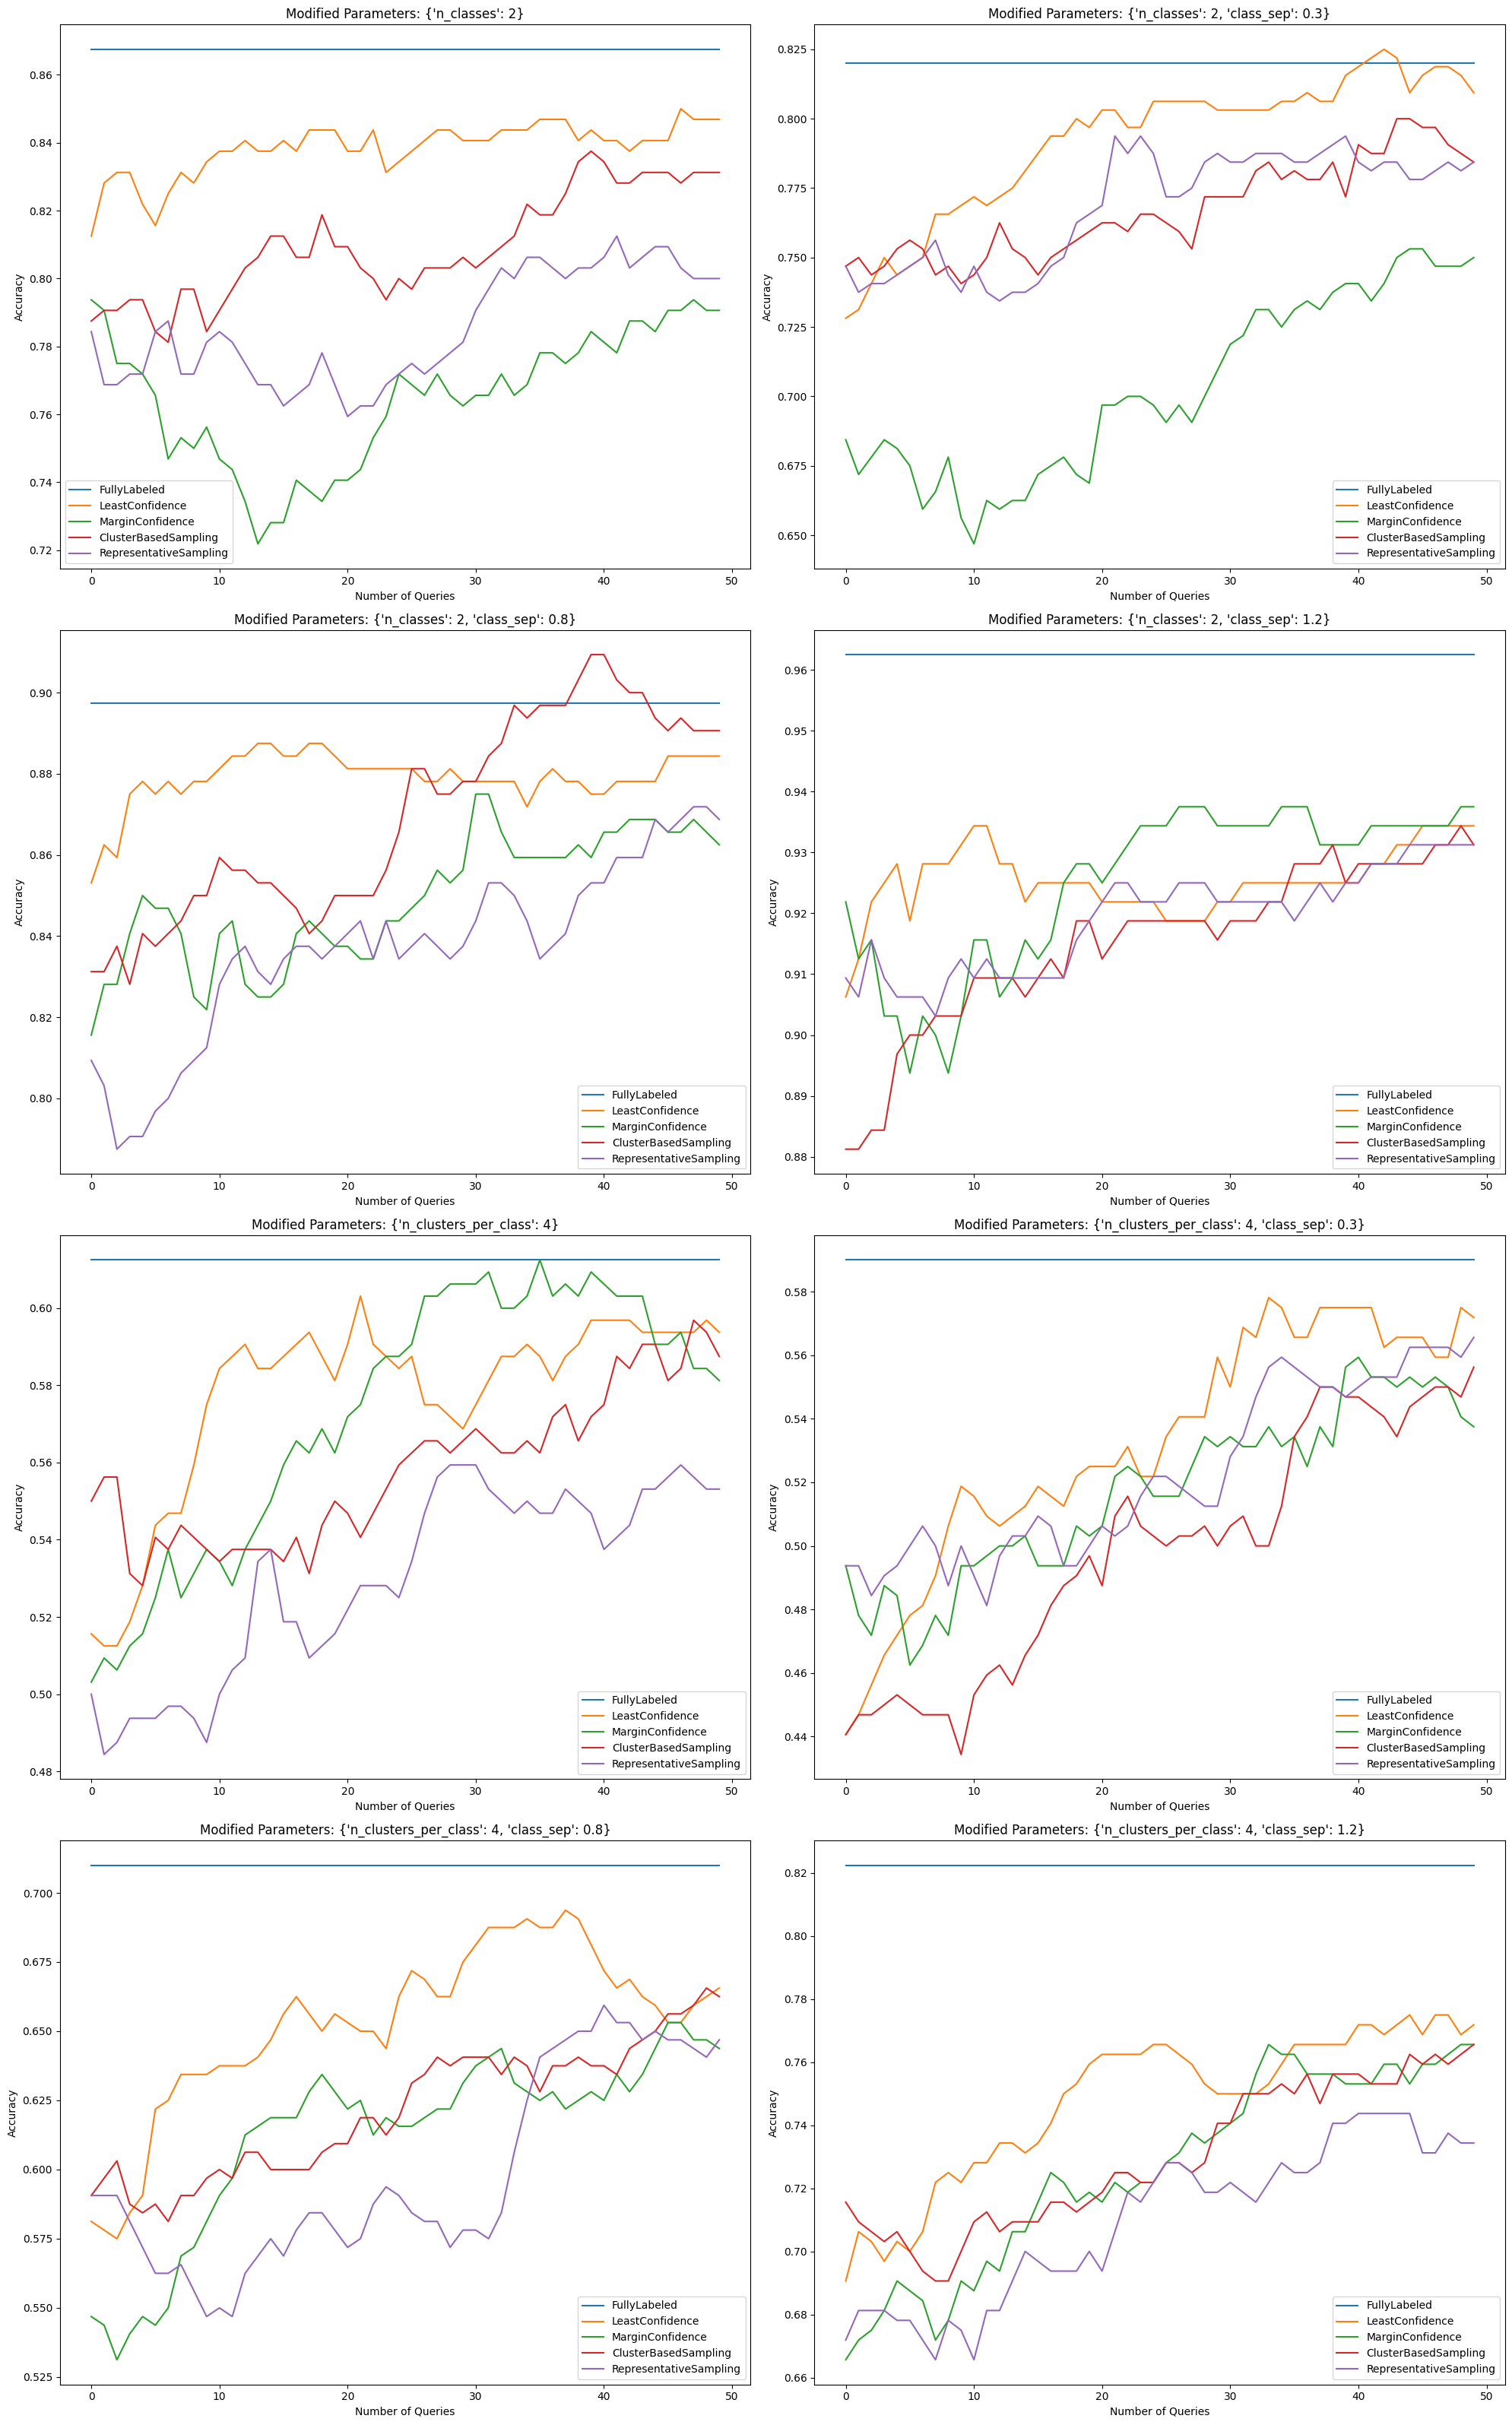

In [19]:
# Ergebnisse plotten
num_params = len(results)
fig, axes = plt.subplots(nrows=(num_params + 1) // 2, ncols=2, figsize=(20, num_params * 4))
axes = axes.flatten()

for idx, (params, strategy_results) in enumerate(results.items()):
    modified_params = eval(params)  # Konvertiere den String zurück zu einem Dictionary
    diff_params = {k: v for k, v in modified_params.items() if base_params.get(k) != v}  # Vergleiche mit base_params
    for strategy_name, accuracies in strategy_results.items():
        axes[idx].plot(accuracies, label=strategy_name)
    axes[idx].set_title(f"Modified Parameters: {diff_params}")  # Zeige nur veränderte Parameter
    axes[idx].set_xlabel('Number of Queries')
    axes[idx].set_ylabel('Accuracy')
    axes[idx].legend()


plt.tight_layout()
plt.show()

Schwankende Performance von FullyLabeled:
Variabilität der Daten: Die make_classification-Funktion erzeugt Daten, die abhängig von den gegebenen Parametern variieren können. Verschiedene Kombinationen von class_sep, n_clusters_per_class usw. können unterschiedlich schwierige Datensätze erzeugen, was die Performance beeinflusst.
Modellkapazität und Overfitting: Ein vollständig gelabeltes Modell nutzt zwar alle verfügbaren Daten, aber es könnte immer noch Overfitting betreiben, insbesondere wenn die Daten sehr komplex oder die Klassen schlecht separierbar sind. Dies könnte erklären, warum es manchmal nicht besser als die Active Learning-Strategien abschneidet, die möglicherweise eine bessere Generalisierung durch die schrittweise Hinzunahme von Trainingsdaten erreichen.
Zufälligkeit: Die Zufälligkeit in der Datenaufteilung und anfänglichen Modellausbildung kann ebenfalls zu Unterschieden in der Leistung führen.

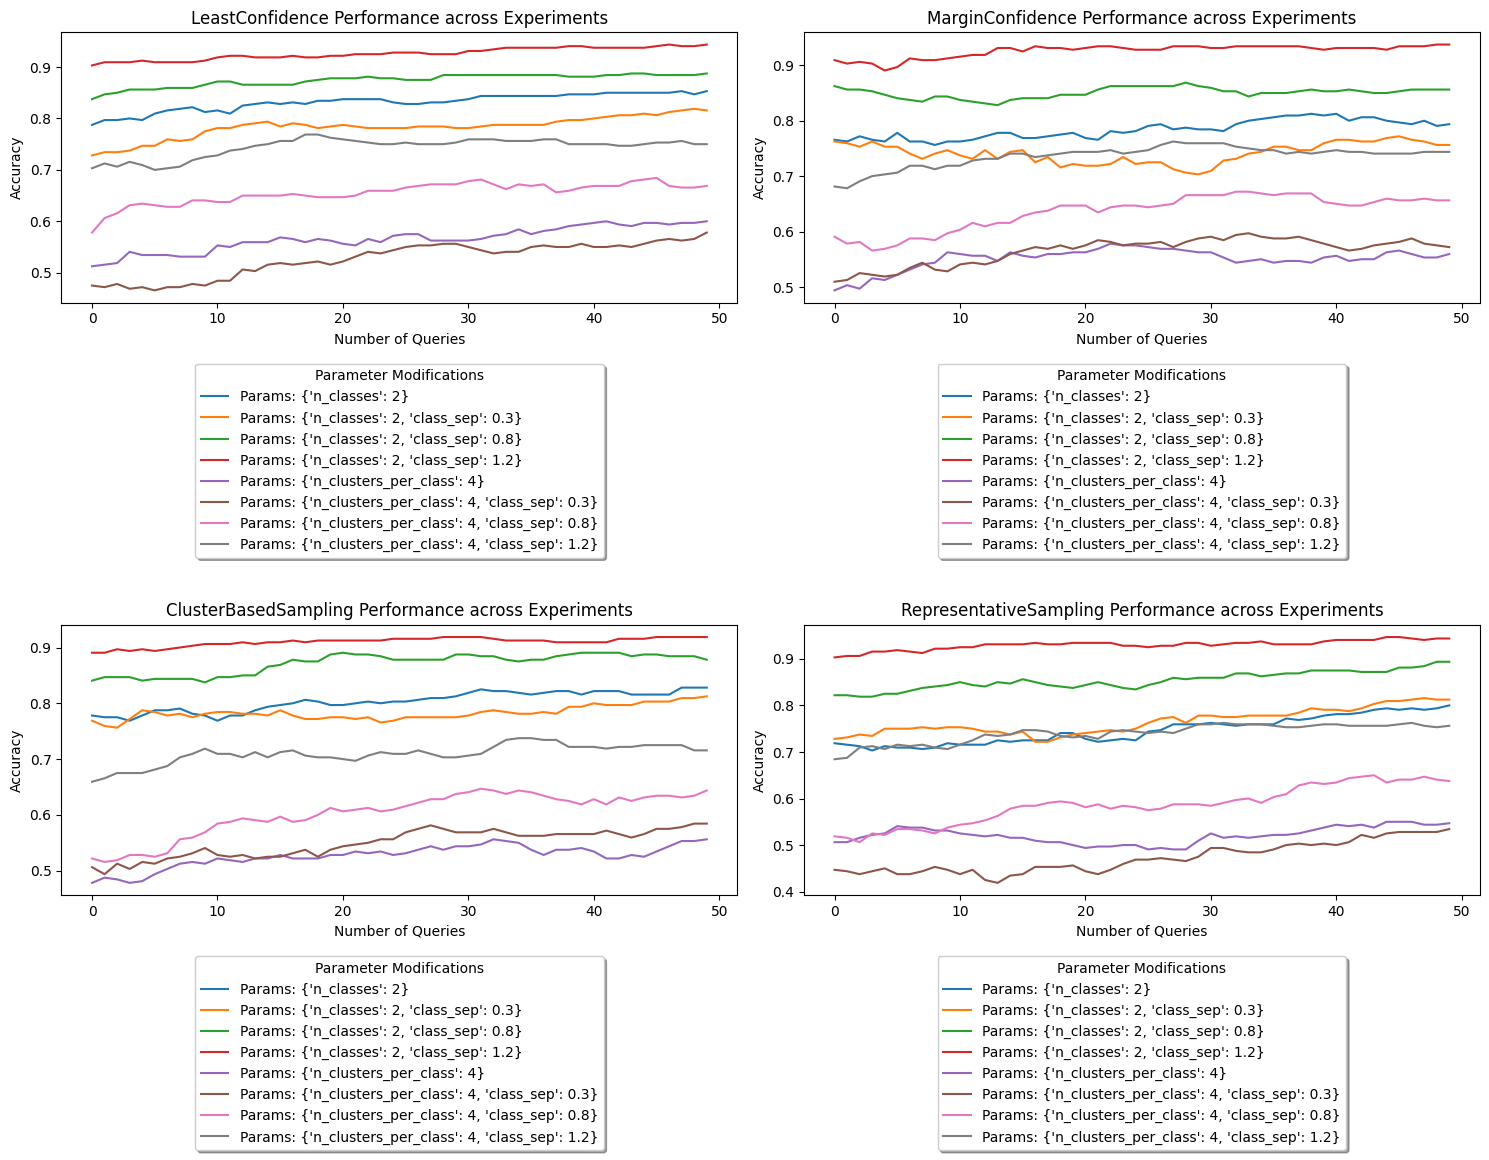

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))  # Größe angepasst für mehr Platz
axes = axes.flatten()

strategy_names = ['LeastConfidence', 'MarginConfidence', 'ClusterBasedSampling', 'RepresentativeSampling']
strategy_axes = {name: ax for name, ax in zip(strategy_names, axes)}

# Durchlaufe jedes Ergebnis und füge die Daten zu den entsprechenden Strategie-Plots hinzu
for params, strategy_results in results.items():
    modified_params = eval(params)
    diff_params = {k: v for k, v in modified_params.items() if base_params.get(k) != v}
    for strategy_name, accuracies in strategy_results.items():
        ax = strategy_axes[strategy_name]
        ax.plot(accuracies, label=f"Params: {diff_params}")

# Setze Titel, Labels und Legenden für jeden Subplot
for strategy_name, ax in strategy_axes.items():
    ax.set_title(f'{strategy_name} Performance across Experiments')
    ax.set_xlabel('Number of Queries')
    ax.set_ylabel('Accuracy')
    # Position der Legende unter dem Plot
    ax.legend(title='Parameter Modifications', loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)

plt.tight_layout()
plt.show()
